# Sequential Patterns and Advanced Clustering

* Sequential Pattern Mining: Convert the time series into a discrete format (e.g., by using SAX) and extract the most frequent sequential patterns (of at least length 3/4) using different values of support, then discuss the most interesting sequences
* Advanced Clustering: On a dataset already prepared for one of the previous tasks in Module 1 or Module 2, run at least one clustering algorithm presented in the advanced clustering lectures (e.g. X-Means, Bisecting K-Means, OPTICS). Discuss the results that you find analyzing the clusters and reporting external validation measures (e.g SSE, silhouette)

# Sequential Pattern Mining

#### Importing libraries

In [228]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import read_csv
from numpy import dstack

#### Loading Data

In [229]:
# Load single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [230]:
# Load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

In [231]:
# Load a dataset group, such as train or test
def load_dataset(group):
    filepath = group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(group + '/y_'+group+'.txt')
    return X, y

In [232]:
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [233]:
# Load all train
X_train, y_train = load_dataset('train')
print('timesteps:', len(X_train[0]))
print('input dimension:', len(X_train[0][0]))
print('len of X_train:', len(X_train))
n_classes = _count_classes(y_train)
print('n classes:', n_classes)

timesteps: 128
input dimension: 9
len of X_train: 7352
n classes: 6


In [234]:
# Load all test
X_test, y_test = load_dataset('test')
print('timesteps:', len(X_test[0]))
print('input dimension:', len(X_test[0][0]))
print('len of X_test:', len(X_test))
n_classes = _count_classes(y_test)
print('n classes:', n_classes)

timesteps: 128
input dimension: 9
len of X_test: 2947
n classes: 6


#### Plot time series data for one subject

In [235]:
sub_map = load_file('train/subject_train.txt')
train_subjects = np.unique(sub_map)
print(train_subjects)

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]


In [236]:
# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
    # get row indexes for the subject id
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    # return the selected samples
    return X[ix, :, :], y[ix]

In [237]:
# convert a series of windows to a 1D list
def to_series(windows):
    series = list()
    for window in windows:
        # remove the overlap from the window
        half = int(len(window) / 2) - 1
        for value in window[-half:]:
            series.append(value)
    return series

In [238]:
# plot the data for one subject
def plot_subject(X, y):
    plt.figure()
    # determine the total number of plots
    n, off = X.shape[2] + 1, 0
    # plot total acc
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]))
        plt.title('total acc '+str(i), y=0, loc='left')
        off += 1
    # plot body acc
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]))
        plt.title('body acc '+str(i), y=0, loc='left')
        off += 1
    # plot body gyro
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]))
        plt.title('body gyro '+str(i), y=0, loc='left')
        off += 1
    # plot activities
    plt.subplot(n, 1, n)
    plt.plot(y)
    plt.title('activity', y=0, loc='left')
    plt.show()

In [239]:
# get the data for one subject
sub_id = train_subjects[0]
X_sub, y_sub = data_for_subject(X_train, y_train, sub_map, sub_id)
print(X_sub.shape, y_sub.shape)

(347, 128, 9) (347, 1)


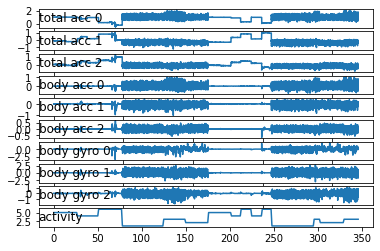

In [240]:
# plot data for subject
plot_subject(X_sub, y_sub)

#### Total acc x (Time series analysed)

The acceleration signal from the smartphone accelerometer X axis in standard gravity units 'g'. Every row shows a 128 element vector. 


In [241]:
X_train = X_train[:,:,0]
X_train.shape

(7352, 128)

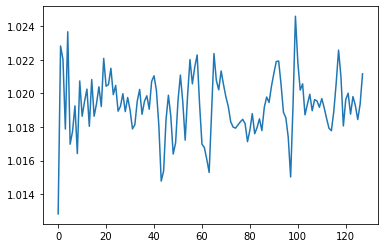

In [242]:
plt.plot(X_train[0])
plt.show()

In [243]:
X_test = X_test[:,:,0]
X_test.shape

(2947, 128)

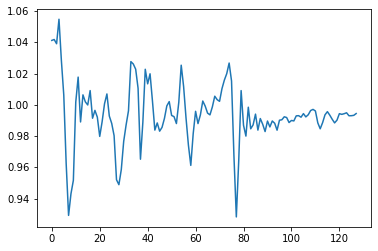

In [244]:
plt.plot(X_test[0])
plt.show()

#### Scaling time series & SAX transform

In [245]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import SymbolicAggregateApproximation

In [246]:
X_train.values

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
ts = scaler.fit_transform(X_train[0].reshape(1,-1))

In [187]:
type(ts)

numpy.ndarray

In [182]:
n_paa_segments = 30
n_sax_symbols = 10
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
ts_sax = sax.fit_transform(ts)
sax_ts_inv = sax.inverse_transform(ts_sax)

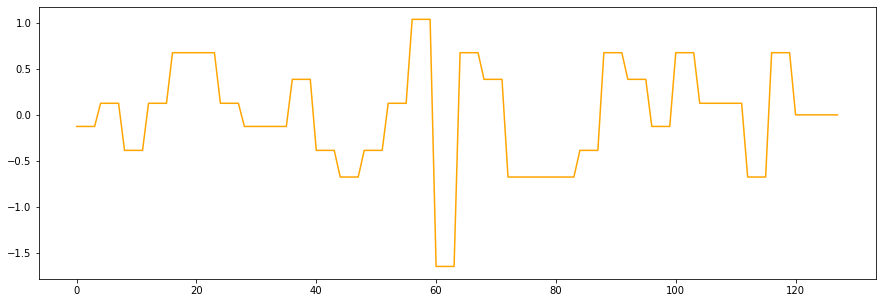

In [183]:
plt.figure(figsize = (15,5))
plt.plot(sax_ts_inv.ravel(), c = 'orange')
plt.show()

In [184]:
map_symbols = {k: v for v, k in enumerate(np.unique(sax_ts_inv.ravel()))}
map_symbols

{-1.6448536269514729: 0,
 -0.6744897501960817: 1,
 -0.38532046640756773: 2,
 -0.12566134685507402: 3,
 0.0: 4,
 0.12566134685507416: 5,
 0.38532046640756773: 6,
 0.6744897501960817: 7,
 1.0364333894937898: 8}

In [185]:
X_seq = list()
for x in sax_ts_inv:
    X_seq.append([map_symbols.get(v, -1) for v in x.ravel()])

In [186]:
len(X_seq[0])

128

In [115]:
# Creating Transactional Dataset

In [116]:
# Items: Dalla sequenza della sax sono stati presi i valori di ogni singolo elemento (items)
new_seq = []
for x in X_seq:
    new_seq.append(x[0])

In [117]:
len(new_seq)

1

In [103]:
# Elements: Ogni 4 items sono stati raccolti in un element (ogni element rappresenta 2 ore)

In [118]:
X_seq2H = []
i = 0
for i in range(0, 1):
    X_seq2H.append((new_seq[i],new_seq[i+1],new_seq[i+2],new_seq[i+3]))

IndexError: list index out of range

In [19]:
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
ts = scaler.fit_transform(X_train.reshape(1,-1))

In [20]:
# SAX transform
n_paa_segments = 20
n_sax_symbols =10
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
ts_sax = sax.fit_transform(ts)
sax_ts_inv = sax.inverse_transform(ts_sax)

In [21]:
ts_sax.ravel()

array([5, 5, 4, 5, 4, 5, 5, 5, 5, 5, 3, 4, 4, 4, 5, 4, 4, 4, 5, 5])

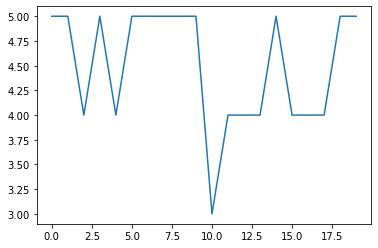

In [22]:
plt.plot(ts_sax.ravel())
plt.show()

#### Sequential pattern mining

In [23]:
from prefixspan import PrefixSpan

In [24]:
X_seq = list()
for x in ts_sax:
    X_seq.append(x.ravel())

In [25]:
X_seq

[array([5, 5, 4, 5, 4, 5, 5, 5, 5, 5, 3, 4, 4, 4, 5, 4, 4, 4, 5, 5])]

In [26]:
ps = PrefixSpan(X_seq)

In [27]:
ps

In [28]:
ps.frequent(3) # param is min freq absolute

[]

In [29]:
ps.frequent(3, closed = True)

[]

In [30]:
ps.topk(3) # param is number of patterns to be returned

[(1, [5]), (1, [5, 5]), (1, [5, 5, 4])]

In [31]:
ps.topk(10)

[(1, [5]),
 (1, [5, 5]),
 (1, [5, 5, 4]),
 (1, [5, 5, 4, 5]),
 (1, [5, 5, 4, 5, 4]),
 (1, [5, 5, 4, 5, 4, 5]),
 (1, [5, 5, 4, 5, 4, 5, 5]),
 (1, [5, 5, 4, 5, 4, 5, 5, 5]),
 (1, [5, 5, 4, 5, 4, 5, 5, 5, 5]),
 (1, [5, 5, 4, 5, 4, 5, 5, 5, 5, 5])]

In [32]:
from spmf import Spmf

In [33]:

spmf = Spmf("GSP", spmf_bin_location_dir="C:\\Users\\Cosimo\\Documents\\UNIVERSITA' & CO\\Università\\Magistrale - Data Science & Business Informatics UniPi\\Data mining 1 e 2\\DM2\\Project\\UCI HAR Dataset",  
            input_direct=ts_sax,
            output_filename="output.txt",
            arguments=[0.5])

spmf.run()
output = spmf.to_pandas_dataframe(pickle=True)
output

FileNotFoundError: spmf.jar not found. Please use the spmf_bin_location_dir argument.

# Advanced Clustering

In [34]:
# Normalized points
# pca?
# x means
# optics

# k mode?
# rock?
# tx means?

##### Load train and test set

In [220]:
df_train_binary = pd.read_csv('csv/train_binary.csv')
df_test_binary = pd.read_csv('csv/test_binary.csv')

In [221]:
df_train_binary['Class'] = 0
df_test_binary['Class'] = 0

df_train_binary.loc[(df_train_binary['Activity']==2), 'Class'] = 1
df_test_binary.loc[(df_test_binary['Activity']==2), 'Class'] = 1

In [222]:
X_train = df_train_binary.drop(['subject','Activity','ActivityName','Class'], axis = 1)
y_train = df_train_binary.Class

In [223]:
X_test = df_test_binary.drop(['subject','Activity','ActivityName','Class'], axis = 1)
y_test = df_test_binary.Class

#### PCA

In [224]:
#from sklearn.decomposition import PCA

In [225]:
#pca = PCA(0.85)
#pc = pca.fit_transform(X_train) # << to retain the components in an object
#pc
#
##pca.explained_variance_ratio_
#print ( "Components = ", pca.n_components_ , ";\nTotal explained variance = ",
#      round(pca.explained_variance_ratio_.sum(),5)  )
#
#pca = PCA(n_components=19)
#pca.fit(X_train)
#X_train_pca = pca.transform(X_train)

In [226]:
#X_train_pca

In [227]:
from sklearn import preprocessing


scaler = preprocessing.MinMaxScaler()
names = X_train.columns
d = scaler.fit_transform(X_train)
X_train_norm = pd.DataFrame(d, columns=names)
X_train_norm.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.644292,0.489853,0.433547,0.002361,0.008748,0.043237,0.002444,0.008546,0.038236,0.032638,...,0.475511,0.350991,0.147940,0.437030,0.515200,0.267793,0.491741,0.079377,0.798251,0.470687
1,0.639209,0.491795,0.438240,0.000877,0.012824,0.019839,0.000596,0.012749,0.021157,0.028466,...,0.594891,0.201676,0.070666,0.521131,0.496283,0.133774,0.853429,0.077606,0.798487,0.472842
2,0.639827,0.490266,0.443269,0.002310,0.017058,0.010528,0.001740,0.018464,0.011266,0.030654,...,0.726616,0.304605,0.122488,0.434094,0.588950,0.550707,0.906041,0.075533,0.798722,0.475441
3,0.639587,0.486900,0.438359,0.001954,0.008596,0.004662,0.001450,0.008767,0.005349,0.030654,...,0.721515,0.442374,0.264192,0.475464,0.493554,0.820538,0.257822,0.075675,0.799600,0.476168
4,0.638314,0.491715,0.442319,0.000931,0.009945,0.004759,0.000839,0.010331,0.004779,0.028765,...,0.558768,0.324393,0.153612,0.556466,0.561271,0.847339,0.192392,0.076067,0.801776,0.478054


In [44]:
X = transformer.transform(X_train_pca)
X

array([[-0.19662389, -0.15255825, -0.83962848, ..., -0.38846515,
        -1.09737644,  0.77932238],
       [-0.19796804, -0.06309945, -1.08012823, ...,  0.2340361 ,
         0.72066602,  0.28161426],
       [-0.1925839 ,  0.09619196, -1.21402053, ...,  0.03159335,
         0.51646754,  0.90577465],
       ...,
       [ 0.8182536 , -1.35464447,  0.50097712, ...,  1.36398796,
         0.91349872,  0.02466186],
       [ 0.7793266 , -1.50302817,  0.50099903, ...,  1.30611345,
         0.59370994, -0.11738809],
       [ 0.78618374, -1.22894201,  0.09566229, ..., -1.01288434,
        -0.72193966, -0.42170768]])

##### X-Means

In [123]:
from pyclustering.cluster import cluster_visualizer, cluster_visualizer_multidim
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES

In [125]:
# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(X_train, amount_initial_centers).initialize()

In [126]:
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(X_train, initial_centers, 20)
xmeans_instance.process()

In [127]:
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()

In [128]:
print('N of clusters:', len(clusters))

N of clusters: 20


In [129]:
np.array(centers)

array([[ 0.27773499, -0.01670919, -0.10947012, ..., -0.74691539,
         0.20254591,  0.09457289],
       [ 0.27510965, -0.01683124, -0.11526855, ..., -0.68662277,
        -0.01013255, -0.13499344],
       [ 0.27763088, -0.01693339, -0.10845323, ..., -0.7885846 ,
         0.12116247, -0.03556201],
       ...,
       [ 0.27662169, -0.02095584, -0.11183304, ..., -0.70783532,
         0.27209758,  0.08278599],
       [ 0.27920544, -0.02016648, -0.11539493, ..., -0.72580825,
         0.22209614,  0.14326462],
       [ 0.25964888, -0.0221415 , -0.11458868, ..., -0.4243206 ,
         0.29739036,  0.3644718 ]])

In [130]:
# Print total sum of metric errors
print("Total WCE:", xmeans_instance.get_total_wce())

Total WCE: 107225.08535272756


In [137]:
# Visualize clustering results
visualizer = cluster_visualizer_multidim()
visualizer.append_clusters(clusters, X_train.empty())
visualizer.append_cluster(centers, None, marker='*', markersize=10)
visualizer.show()

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

#### OPTICS

In [63]:
from sklearn.cluster import OPTICS

In [64]:
optics = OPTICS(min_samples=5, max_eps=np.inf)
optics.fit(X)

OPTICS()

In [65]:
from sklearn.metrics import silhouette_score

In [66]:
silhouette_score(X[optics.labels_ != -1], optics.labels_[optics.labels_ != -1])

0.3614912694329948

In [67]:
for cluster_id in np.unique(optics.labels_)[:20]:
    indexes = np.where(optics.labels_==cluster_id)
    plt.scatter(X[indexes,i], X[indexes,j], alpha=0.4)

NameError: name 'i' is not defined

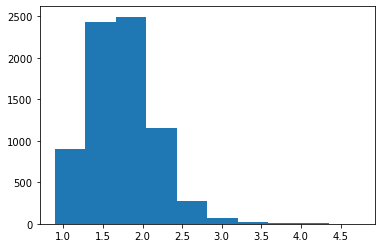

In [68]:
plt.hist(optics.reachability_[1:])
plt.show()

In [71]:
optics = OPTICS(min_samples=5, max_eps=np.inf, cluster_method='dbscan')
optics.fit(X)

OPTICS(cluster_method='dbscan')

In [72]:
silhouette_score(X[optics.labels_ != -1], optics.labels_[optics.labels_ != -1])

ValueError: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.

In [ ]:
np.unique(optics.labels_)

In [ ]:
np.unique(optics.labels_, return_counts=True)

#### Rock

In [73]:
from pyclustering.cluster import rock

In [74]:
rc = rock.rock(X, eps=0.7, number_clusters=4, threshold=0.5)
rc.process()

In [75]:
clusters = rc.get_clusters()

In [76]:
clusters

[[0],
 [1],
 [2],
 [3],
 [4],
 [5],
 [6],
 [7],
 [8],
 [9],
 [10],
 [11],
 [12],
 [13],
 [14],
 [15],
 [16],
 [17],
 [18],
 [19],
 [20],
 [21],
 [22],
 [23],
 [24],
 [25],
 [26],
 [27],
 [28],
 [29],
 [30],
 [31],
 [32],
 [33],
 [34],
 [35],
 [36],
 [37],
 [38],
 [39],
 [40],
 [41],
 [42],
 [43],
 [44],
 [45],
 [46],
 [47],
 [48],
 [49],
 [50],
 [51],
 [52],
 [53],
 [54],
 [55],
 [56],
 [57],
 [58],
 [59],
 [60],
 [61],
 [62],
 [63],
 [64],
 [65],
 [66],
 [67],
 [68],
 [69],
 [70],
 [71],
 [72],
 [73],
 [74],
 [75],
 [76],
 [77],
 [78],
 [79],
 [80],
 [81],
 [82],
 [83],
 [84],
 [85],
 [86],
 [87],
 [88],
 [89],
 [90],
 [91],
 [92],
 [93],
 [94],
 [95],
 [96],
 [97],
 [98],
 [99],
 [100],
 [101],
 [102],
 [103],
 [104],
 [105],
 [106],
 [107],
 [108],
 [109],
 [110],
 [111],
 [112],
 [113],
 [114],
 [115],
 [116],
 [117],
 [118],
 [119],
 [120],
 [121],
 [122],
 [123],
 [124],
 [125],
 [126],
 [127],
 [128],
 [129],
 [130],
 [131],
 [132],
 [133],
 [134],
 [135],
 [136],
 [137],
 [138]

In [78]:
for i, indexes in enumerate(clusters):
    print(i, X[indexes[:5]])

0 [[-0.19662389 -0.15255825 -0.83962848  1.1404544   1.22801488 -0.12850329
   0.53131272  0.66963507 -1.22749856 -0.35606265 -0.07080621  0.10957641
   1.40588253  1.78339978  2.17053661  0.03526636 -0.38846515 -1.09737644
   0.77932238]]
1 [[-0.19796804 -0.06309945 -1.08012823  0.58589241  0.60258455  0.68781289
  -0.55023653 -0.65298489 -0.60749249 -0.91381063 -0.37551526 -0.05648906
   0.36019053  0.44180735  0.4048328   0.26390217  0.2340361   0.72066602
   0.28161426]]
2 [[-0.1925839   0.09619196 -1.21402053  0.46905519  0.21808549  0.00927478
   0.06058327  0.12946803 -0.04367297 -0.20237197 -0.18460283  0.43807214
  -0.09694216  0.28676704  0.27008332 -0.44052247  0.03159335  0.51646754
   0.90577465]]
3 [[-0.21062369  0.358713   -1.13702307  0.15516726  0.67545061  0.9901639
  -0.23411165 -0.61652109  0.30790347  0.51385079 -0.24195707 -0.424878
  -0.96416292  0.12940904 -0.20350904 -0.1937355   0.0966893  -0.45833807
  -0.082461  ]]
4 [[-0.21700289  0.47322203 -1.21090927  0.

317 [[ 0.76668051 -0.79937123  0.08698303  1.01373495 -0.63731559  0.25498111
  -1.2099617  -0.48616004 -0.46074268 -0.52869176 -0.70563733 -1.15984253
   0.67881867  0.56356767 -0.91125057 -0.18580257 -1.0510551  -1.58053099
   1.18252852]]
318 [[ 0.7916093  -0.86101234  0.22495424  1.15406334 -0.2173256   0.26826421
  -0.78234845  0.34960207 -0.03308313  0.22309879 -0.50552768 -1.85217716
   0.32089659  0.52582095 -1.02820409 -0.63380178 -1.04017299  0.02047643
   0.5575374 ]]
319 [[ 0.77253278 -0.84447589  0.14554379  1.29968148 -0.21246609 -0.0418834
  -0.28129655  0.23868648  0.06956072  1.50145154 -0.9795339  -2.90281209
   0.31926745  1.36548921 -1.22731353 -0.36781893 -0.90561854  0.62743492
  -1.53968757]]
320 [[ 0.70828268 -0.93489641  0.26421273  1.07204011 -0.11444557  0.63373577
  -0.72961273  0.04210932 -0.37457046  1.65422973 -0.34308798 -2.52796854
   0.34465735  1.57249557 -0.91940902 -0.33393261  0.760043    0.07036735
  -1.10998065]]
321 [[ 0.68981778 -1.32194957  0.

634 [[ 0.74218671  0.06327955 -0.32146163 -1.46039798 -0.5882501   0.30498357
   0.97419243  0.82330574 -1.3071345   0.13530114  0.34434624 -0.38030039
  -0.05094987  0.10564861 -0.27775638 -0.12489078 -0.08509121 -1.172414
   0.61036317]]
635 [[ 0.74590294  0.13671787 -0.44813588 -1.50527078 -0.71652193  0.36608912
   0.87543835  0.91739652 -1.75225393 -0.17629967 -0.21591828 -0.19493832
  -0.19607119  0.0547303   0.07464825  0.97922598  0.50017694 -0.48331575
   0.35615369]]
636 [[ 0.73650794  0.05406942 -0.34165112 -1.56378019 -0.5354211   0.7632981
   0.66590973  0.74494111 -1.96108653  0.2824831  -0.65272483  0.21857291
  -0.30681537  0.54575151 -0.00582494  0.73742394  1.2561543   0.16521341
   0.5696326 ]]
637 [[ 7.65481198e-01 -5.27009403e-02 -1.49791419e-02 -1.59830146e+00
  -1.04471371e-03 -1.10883219e-01  5.52546081e-02  3.47526185e-01
   4.73891315e-01  4.75989799e-01  9.19958432e-01 -1.30284291e+00
   4.95769446e-02 -1.80909037e-01 -1.21632632e+00  5.95145250e-01
   1.9786

   1.11352858e-01  2.70802048e-01 -4.45469666e-01]]
926 [[ 0.76226941  0.13010973 -0.05214297 -1.72248791 -0.26153683  0.29304835
  -0.42770456  0.68341136 -0.67044069  0.11115731  0.45378834  0.27422262
  -0.45700265  0.00834856 -0.61098204 -1.82835539 -0.23008356  0.33001651
  -1.30100083]]
927 [[ 0.7677541   0.15920336 -0.06070761 -1.4890655  -0.10141978  0.4948303
  -0.35442255  0.41281509 -0.0964686   0.6744566   0.61569686  0.65911304
  -0.5328145  -0.55619006 -0.44390413 -1.91917648 -0.66030211  1.2542503
   0.35699729]]
928 [[ 0.7979409   0.23458332 -0.17497024 -1.38938533 -0.10260841  0.2974607
  -0.18803206  0.72661349  0.27304     0.5295091   0.55630718 -0.1007435
  -0.35839084  0.12820442  0.37290018 -1.51692691 -0.80435362  0.10092332
  -0.56598717]]
929 [[ 0.82994275  0.20863504 -0.30020193 -1.32613533  0.19550578  0.88868362
   0.10791535 -0.00445014 -0.54870191 -0.97387156 -0.35999713 -0.38351344
  -0.81746574 -0.67029443 -0.40218279 -0.82701096 -0.2473814  -0.43841419


1132 [[ 0.77956029 -0.65139629  0.02801874 -0.94646969  0.71322904 -0.73958928
  -0.03837632  0.39722805 -0.15999876 -0.76254858 -0.28737495  0.07841944
   0.19539742  0.23393361 -0.90977915 -0.31134896  0.30338479 -1.39446364
   0.69739295]]
1133 [[ 0.82044198 -0.52378321  0.14874718 -0.66932884  0.3598406  -0.6864786
  -0.52705549  0.60074198 -0.17320686 -1.14174534 -0.10400198  0.17828632
  -0.00550923  0.39997864 -0.33658071 -0.7978423   0.87063695  0.14629241
   0.93003361]]
1134 [[ 8.56885864e-01 -3.11027359e-01  2.38912209e-02 -5.02164919e-01
   5.90384085e-01 -7.99164397e-01  1.70196346e-01  4.93346832e-01
  -3.16897655e-01 -5.34308561e-01 -3.21943605e-01  1.27738139e-03
  -5.56268920e-01  5.97851699e-01  3.99759319e-01 -1.15983789e+00
   5.58093654e-01  1.39550225e+00  1.11130178e+00]]
1135 [[ 0.88770935 -0.28491279  0.25321054 -0.62521423  0.34349266 -0.27120549
  -0.78569866  0.72965563  0.02802917 -0.89120806  0.28911874  0.30103681
   0.06560543  0.86454246 -0.37677476 -1.

1356 [[ 0.00297268 -1.4523926  -0.34095643  0.36825242  1.13919758  1.38353759
   0.60713227  0.12362784  0.27867972  1.06308188 -0.16476346  0.60435661
   0.34825531 -1.47403743 -0.92775622 -0.72584128 -0.1382003  -0.51178191
  -1.03609074]]
1357 [[-0.01862251 -0.61432711 -0.87435877 -0.31238861  0.08139825  1.0175188
   0.27728374 -0.30145608  0.91599093  0.694916   -0.76445239  0.22278499
  -0.37488735 -1.41838927  0.91100802 -0.08822457 -0.59689092  0.38148181
  -0.4928128 ]]
1358 [[-0.03083863 -0.5059901  -0.97193004 -0.18031477 -0.00325267  0.95443325
   0.11864775 -0.27361592  0.241205    0.63611844 -0.54262437 -0.40133491
   0.03051328 -1.09855482  0.8229649  -0.05816751 -1.05637211 -0.05101825
  -0.26568386]]
1359 [[-0.07243954 -0.30378452 -0.98327169 -0.8875435  -0.20027226  1.4495786
   0.15570766 -0.54180901  0.90077591 -0.44183492 -0.2122328  -0.24356936
   0.11435585 -0.09673226 -0.19666671  0.48279646  1.4384141  -1.31633001
   0.10485947]]
1360 [[-0.19134795  0.19640263

1637 [[-0.18569921 -0.34529095 -0.8270625   1.20982329  1.25299319  0.48225365
   0.05009736 -0.11420071 -0.89687091  0.01573274 -0.03177282  0.37013923
  -0.26350714 -0.75239526  0.3334704   0.02333188 -0.82688726  0.12322576
  -0.25020442]]
1638 [[-0.20774241  0.21163627 -1.08112757  0.70584714  0.58129857  0.09518363
  -0.09102085 -0.08700014 -0.4985766  -0.18470583  0.11203369 -0.03909473
  -0.34284549 -0.14119587  0.73460366 -0.45134294 -0.35132701  0.10715434
   0.29822811]]
1639 [[-0.20434834  0.23973943 -1.14286588  0.70016147  0.10844003 -0.87615455
   0.05067748  0.64003626 -0.38804235  0.2918393  -0.36916841 -0.25080215
   0.75516045 -0.64247996  0.78346239  0.0425503  -0.22297926  0.18793392
   0.47693446]]
1640 [[-0.19116099  0.43011219 -1.1277156   0.11020914 -0.1284901  -0.50371863
  -0.05408687  0.10294411  0.157506    0.60859863 -0.18256971  0.30003884
   0.92056764  0.42071408 -0.08652664 -0.40384664  0.5352185   0.57524021
  -0.27559377]]
1641 [[-0.19388614  0.509733

1927 [[-0.18025193  0.3871373  -0.35778942 -0.4361191  -0.32269731  0.69313462
  -0.08804215 -0.46306302 -0.34026147  0.30937181  0.26581949  1.33251696
   0.46374993 -1.02870587 -0.46527095 -0.03758038  0.22375486 -0.18770874
   0.51711992]]
1928 [[-0.1568714   0.50606334 -0.56260603 -0.78188035 -0.42903403  1.16897612
  -0.00414198 -0.93373493  0.21812836 -0.17812243 -0.10069783 -0.14561836
  -0.32815721 -0.5346617   0.53422262  0.48434599  0.55658588 -1.17384225
  -0.52867068]]
1929 [[-0.18362262  0.52475927 -0.53676645 -0.46848234 -0.47273217  0.86798994
   0.21952028 -0.64742147  0.26251797 -0.1231478   0.21354143  0.38718826
   0.22856947  0.4120203   0.22038366 -0.41504872  1.44230937 -0.77949641
  -0.39171226]]
1930 [[-0.23366882  0.58179744 -0.46857384  0.08932116  0.10834293  0.2537824
  -0.32729821 -1.03104281 -0.11667854 -0.4182359   0.16752442  0.54954426
  -0.32086168  0.12229168 -0.22157706 -0.19537622  1.0345868  -0.03193119
   0.33765053]]
1931 [[-0.25231313  0.8933421

   0.23749519]]
2198 [[ 0.62608685 -1.40580714  0.32465299  0.12208051  0.72913807 -0.13363789
  -0.9531446  -0.09353526 -0.29568786  1.44842326 -0.42251577 -1.66957245
   0.43185378  1.34760986 -0.0567845  -1.03760839  0.59966782  3.11981
  -0.12399263]]
2199 [[ 0.58664552 -1.47624857  0.49107247  0.21225942  0.71717601  0.06710102
  -1.02215729 -0.03701734  0.03231098  1.67325769  0.53375208 -2.14360945
   0.583956    1.03329392 -0.73297112 -0.4703472  -0.10157822  0.36702197
  -2.26690919]]
2200 [[ 0.66667589 -1.10484418  0.18194572  0.25309066  0.70475663 -0.22958852
  -0.91579653 -0.31326901  0.56416888  1.55268967 -0.42235752 -1.72859712
   0.44726114  1.70609588  0.01258775  0.45603082 -0.5391617   0.92652602
  -0.50763983]]
2201 [[ 6.89383687e-01 -8.09260305e-01 -9.79442599e-04 -3.11284645e-02
   9.83898412e-01 -9.43486471e-01 -1.67838760e-01 -4.43785452e-01
   2.55342786e-01  1.33825528e+00 -1.19972622e+00 -2.31155947e+00
   5.47355345e-01  1.72127337e+00  2.36755885e-01 -6.47

  -1.16271868]]
2458 [[-0.09716132  0.23642209  1.43380188 -1.22630357 -1.07201659  0.10778002
  -0.16226143  0.59630245  1.26746472 -0.70588193  0.90578868 -0.18437234
  -1.26328323  0.00966819  1.16318224 -0.23440649  0.39478909  0.34046591
  -1.12483086]]
2459 [[-0.09049737 -0.20368447  1.46205273 -1.33634902 -1.08376491  0.46152746
  -0.11027282  0.92770526  2.22470889 -0.84845768  0.1456071  -0.3303436
  -1.24214079 -0.80206049 -0.42312841  0.22384451 -0.0886521   0.8784499
  -0.68604542]]
2460 [[-0.08916349 -0.27098303  1.55701739 -1.23838712 -0.8462483   0.55534563
  -0.00987109  1.07517544  1.75057244 -0.50128356  0.36547163 -0.58277966
  -1.23648538 -0.82796334 -0.61652558 -0.01967851  0.17776378  0.64963684
  -0.57039668]]
2461 [[-0.1585414  -0.09213306  1.53327142 -0.49662158 -0.14831885  0.09850508
   0.01771166  0.48967139  0.73052952 -0.38426323  0.78828848 -0.33173028
  -0.94297414  0.55673842 -0.41031315 -0.58119472  0.17959282 -0.3740673
  -0.39132724]]
2462 [[-0.08691

  -0.34112446]]
2622 [[-0.22437651  0.48945822  1.3901309  -0.28090169 -0.29637575 -0.25110281
  -0.34951138 -0.38104748  0.8565352   0.45645338 -0.28277876 -0.29234093
   0.35157406  0.61931793 -0.06391659  1.28182674 -0.26742128  0.84795914
   0.54412248]]
2623 [[-0.2365012   0.47462588  1.15856489 -0.14035954 -0.07812737  0.35771329
   0.18776189 -1.00509351  0.24863844  0.92312184 -1.39379439  0.20298795
   1.07717815  0.15949528 -0.38270914  0.50135728  0.21272559 -0.56726254
  -0.79720005]]
2624 [[-0.24147094  0.34520335  1.2611342   0.09599738  0.47287802  0.76547498
   0.18344931 -1.04738915 -0.60786972 -0.16092918 -1.57698579 -0.77160689
   0.39976563 -0.98859206 -0.06670464  0.71372689  1.2061799  -0.06783694
  -1.00443767]]
2625 [[-0.23129733  0.70420746  0.98881329 -0.4415323  -0.21464138  0.43881485
   0.14114301 -1.40915287  0.30203854 -0.86409982 -1.40751866 -0.5151769
  -0.24320558 -0.34613982  0.67865091 -0.10824864  1.28606422  0.80082928
   0.91870642]]
2626 [[-0.164

2862 [[ 0.79008547 -0.90857985  0.17298433  0.44564823  0.47421673 -0.85053837
  -0.75927466 -0.62459915  0.10663694 -1.31327545 -0.44918315 -2.06319706
   1.59471522  0.57157956  0.25310681  0.14894016 -0.73969198 -0.4147478
  -0.77802953]]
2863 [[ 0.87183648 -0.3910355   0.14114078  0.12363867  0.86959067 -1.14297602
  -0.0401743  -0.06123131 -0.35324692 -1.19483451 -0.65310132 -1.94540175
   1.6641769   0.18099101  0.25279444  0.08237037 -1.25801861 -0.69190335
  -1.64961368]]
2864 [[ 0.83475055 -0.52190178  0.26472183  0.36223244  0.53783913 -0.39737764
  -1.14520826 -0.34858474 -0.41004768 -1.03015348 -0.55077234 -1.18289636
   1.90259196  0.23712535 -0.27229763  0.00448726 -1.05231662  0.42462508
  -0.66808719]]
2865 [[ 0.79249346 -0.6548828   0.15045224  0.62175613  0.59035732 -1.00259788
  -1.18812661 -0.1007572  -0.41094828 -0.84609563 -1.3280941  -1.28505171
   1.81702919 -0.2265412   1.03399381 -0.03845577 -0.6213269   1.8251577
   0.46718241]]
2866 [[ 0.7791531  -0.84532626

3121 [[-0.21815113  0.46929564 -1.1360672   0.32836534  0.59801723  0.66015901
  -0.41496342 -0.69539127 -0.32198552 -0.1527681  -0.06671747 -0.44948271
  -0.15460941  0.49480624 -0.31722933  0.01973354  0.19968627  0.36127962
   0.39597878]]
3122 [[-0.23560722  0.83243508 -1.10067995  0.29171973  0.5218053   0.77730231
  -0.63675885 -0.88146909 -0.63002481  0.55284984  0.21868836 -1.05036603
  -0.08837083  0.41795931 -0.36914946  0.00755242  0.25917222 -0.6373399
   0.55378098]]
3123 [[-0.23465448  0.577886   -1.00902793  0.53691133  0.63712629  0.58254922
  -0.75719784 -1.18840756 -0.63842274  0.476739    0.06017347 -1.18863887
   0.2831952   0.30835727 -0.31742863  0.0563929   0.07168495 -0.72024404
   0.24927448]]
3124 [[-0.22607319  0.42584881 -0.65421484  0.38390272  0.22900723 -0.14361891
  -1.42156107  0.03256373  0.37149782  0.75259813  1.19796542 -0.92179059
   0.71942335  1.144325   -0.94432599  0.47738033 -0.47976216  0.1079775
   0.14909202]]
3125 [[-0.23214147  0.54492435

3322 [[-0.06991837 -0.22606518  1.63698524 -1.12453672 -0.6685564   0.71111948
   0.85879313  0.31039083  0.49776077 -0.53477805 -0.17300912  1.43101773
  -0.0223033   1.41112629  1.37156707 -1.1164057   1.30968503 -0.31079029
  -1.047742  ]]
3323 [[-0.22492    -0.2337411   1.81146588  0.73544981  0.61076467  0.61942813
   0.55686243  0.77049479 -0.97904209  0.7378393   0.36137436  1.43811343
   1.48100254  0.79662795 -0.47521481 -0.9932938   0.419643   -0.44818464
   1.03499104]]
3324 [[-0.24123219  0.29919109  1.41039665  0.29523109  0.20633869  0.19356198
   0.46113682  0.24070913 -0.20031875  0.42601087  0.31185079  1.31740295
   0.9289207   1.80760904 -0.95668982 -1.55532375 -0.40160752 -0.43176182
  -0.02922536]]
3325 [[-0.25271399  0.42340936  1.514364    0.25743435  0.18719035 -0.0910537
  -0.14652425  0.53292545 -0.36333589  0.44930337  0.52333383  1.40351451
   0.74406667  0.3251938  -0.24773242 -0.74903782 -0.43124314 -1.35959645
   0.61947449]]
3326 [[-0.24081107 -0.0302860

3601 [[-0.07564592 -0.70894211 -0.80618379 -0.27073215  0.05941347  0.88587906
  -0.02967622 -0.02173428  0.56654593 -0.40802569 -0.07714339  0.35116275
  -0.44065914 -0.24732313  0.56869379  1.09816718  0.05855332 -0.75858477
  -0.44932852]]
3602 [[-0.11965783 -0.38164769 -0.99528044 -0.33513868  0.21642216  0.91214639
   0.07680676 -0.17573699  1.10000808 -0.17485029 -0.43854119  0.34355807
  -0.80986686 -0.41540838  0.75289606  1.27447943  0.08100367 -0.37672549
  -0.54463131]]
3603 [[-0.18992661  0.10177398 -1.00790481  0.12864749  0.49685306  0.77531908
  -0.3866595  -0.58704449  0.2703469   0.00106687 -0.28274969 -0.89515671
  -0.33502762  0.28395915 -0.47505203  0.66836412  0.25826464 -0.26254545
  -0.5390344 ]]
3604 [[-0.19202154 -0.22739658 -0.97450453  0.73983175  0.51219226 -0.17863128
   0.10370083  0.63513249 -0.2953821   0.41209235 -0.58597038 -0.77987875
   0.60820544  0.51407267  0.01372871  0.93602555 -0.19968949  0.76490848
   0.18352649]]
3605 [[-0.19455464 -0.057554

3916 [[ 1.30544418  1.36446907  0.18118835  1.69103165  0.15418782  0.60110834
   0.67496522  1.28970539  0.5386361  -0.99567505 -0.59527247  0.17515115
   0.51637726 -0.62318486 -0.75420203 -0.71069242  0.00467827 -1.46001768
  -0.56926007]]
3917 [[ 1.18785588  1.2965504   0.14529821  1.41457322 -0.21315996  0.67639296
   0.36401918  0.58944333 -0.57838244 -0.53244224 -0.95193265  0.93119479
  -0.74868394 -0.35726857 -0.40100944 -1.43746581  0.61578549  1.20636546
   0.68141734]]
3918 [[ 1.18495071  1.39691478  0.18987755  1.29627344  0.00451294  1.84575096
   0.13307011  0.29138584  0.10894551  0.22350504 -0.56718207  0.92329874
  -1.3011848  -1.28595358  0.60019845 -0.49046755  0.17752686  0.98502761
  -0.25253695]]
3919 [[ 1.25170704e+00  1.76701787e+00  2.37055900e-01  1.22819198e+00
   2.72419619e-01  2.28161913e+00  2.12331792e-01  8.66588161e-01
   4.55284268e-01  4.82172132e-02 -5.23729270e-01  1.26598739e+00
  -2.57998599e-01 -1.41638964e+00  2.92935977e-01  1.16500181e-03
  

  -1.0913622 ]]
4176 [[-0.00166349 -0.79165536 -0.88376977 -0.40534093 -0.65384495 -1.03415998
   0.78360311  0.37709865  0.37985269 -0.07107028 -0.70837409 -0.74475103
   0.11694088 -0.87378762 -1.24177519  0.5984223  -0.70576318 -1.36649073
  -0.33339182]]
4177 [[-0.02455222 -0.69886377 -0.97961899 -0.37677326 -0.58755914 -0.92624309
   1.11019734  0.40243031  0.56216117 -0.64216801 -0.84728847 -0.52773478
  -0.67121256 -0.38244439 -0.6491645   0.18610017 -0.1072243   0.29191934
   0.32326056]]
4178 [[-0.10064981 -0.41661618 -1.05064393  0.02010714 -0.36451845 -1.02006738
   0.7191938   0.70728149  0.07035148 -0.77191569 -0.92371441 -0.28372013
  -0.15505966  0.11633698  0.21133389  0.24492125  0.72864767  1.57418577
   0.74327971]]
4179 [[-0.13278587  0.09020161 -1.09978449 -0.05155042 -0.67502602 -0.71716544
   0.78827977  0.79481553 -0.54860095 -0.31719767 -0.29864712  0.11056946
   0.13704306 -0.25180445  1.37007807  0.68272944  1.47718933  0.68784843
  -0.52997817]]
4180 [[-0.12

4438 [[-0.28317893  1.10407427  1.57841774 -0.09207813 -0.31231503 -0.59774293
  -0.70993611 -0.03811115  0.29798858 -0.19188489  0.79242163 -0.66783638
  -0.67893529  0.48285804  0.01594376 -0.10902849 -0.21890538 -0.39293739
  -0.00234556]]
4439 [[-0.29434478  1.27345415  1.12064072  0.14161855 -0.22666165 -1.31726035
   0.2661988  -0.10760427 -0.10226063  0.09384909 -0.94589457 -1.18781004
  -0.1900314   0.51677407  0.67898188 -0.49215658 -0.30318451  0.50300977
   1.3307416 ]]
4440 [[-0.28648105  1.07656899  1.16863748  0.24212811 -0.0723107  -1.27408223
   0.51292972 -0.02463341  0.02927911 -0.11014632 -0.67431228 -0.7122788
  -0.48462258  0.1818637   0.79747268  0.20764722  0.10244101 -1.29308914
   0.39227064]]
4441 [[-0.27945777  1.08277654  1.28889403  0.2182486  -0.25301504 -1.02904831
   0.48861633  0.01408152  0.03493355 -0.00195927  0.09788005 -0.5984675
  -0.48155542  0.34726722  0.13969325  0.46566708 -0.27006879 -1.27138799
  -0.62911574]]
4442 [[-0.28497225  1.06383559

   0.16336793]]
4728 [[-0.23911868  1.08785138 -0.95996391 -0.00522811 -0.27961101 -0.80966632
   0.21575359 -0.20260274 -0.30547318  0.0658446   0.10957062 -1.01575571
   0.0850732   0.6825009   0.12521458  0.07993637  0.14950147 -0.62456232
   0.17540826]]
4729 [[-0.23148646  0.9355312  -0.84869004 -0.04569657  0.15594346  0.42710501
  -0.21734256 -1.19466973 -0.15028905 -0.65020329  0.50502181 -0.33522401
  -0.66519853  0.2684592  -0.15721471  0.03099235  0.61200246 -0.18679854
   0.4605293 ]]
4730 [[-0.23457555  1.06937734 -0.93511477 -0.14459781  0.05729821  0.1965187
  -0.15817797 -0.92847437  0.16476953 -0.40637685  0.71970536 -0.38916858
  -1.1577582   0.63869512 -0.70448961  0.12501883  0.47659055 -0.33894438
   0.18848319]]
4731 [[-0.24613625  1.16577794 -1.04689832 -0.16679163  0.03434453  0.24423354
   0.32121271 -0.77514781  0.2198652   0.18839448  0.41859917 -0.20412384
  -0.84033973  1.08882831 -0.56436626 -0.54239652  0.29048058  0.12488972
   0.53433354]]
4732 [[-0.248

5021 [[ 1.40351421e+00  1.46733749e+00  5.63275231e-01  3.39927971e+00
  -2.57555474e-01  1.81720808e+00  3.90831352e-01  5.83161405e-01
   1.53069168e+00 -1.47169160e+00  1.38299130e+00  1.07722034e+00
   1.40277648e+00 -7.50250117e-01  2.40128065e-01  1.18418622e+00
   1.11572435e-04  1.22195171e+00  1.04300125e+00]]
5022 [[ 1.43294276  1.95228429  0.42146991  3.14990162  0.27408215  1.79937248
   1.88966848  1.01293443  1.19571881  0.2902421   1.01729387  0.33352513
   1.56875235  0.40667855 -0.61578641  1.29660626 -1.75253922  0.88873158
  -2.73687841]]
5023 [[ 1.21476256  1.18261768  0.29745429  2.32933074 -0.20038104  1.39373896
   0.81269801  0.16313555  0.72132319  0.19531383  1.04780771  0.75074509
   0.81473524  0.07093783 -0.03621805  0.17149489 -2.01758921  1.61162132
  -0.46811639]]
5024 [[ 1.12671067  1.21241779  0.16111238  1.987154   -0.20123405  1.24974035
   0.78661843  0.28776814  0.99907975  0.2970604   1.26865838  1.27230689
   0.70924341  0.63399503  0.89923576 -0

  -0.42115253]]
5327 [[-0.22016576  0.59939193 -1.16922127  0.20881578  0.29906493  0.48451166
  -0.30764936 -0.9887833   0.02873083  0.08055383 -0.1019445  -0.60590497
  -0.01123255  0.20584325  0.26715698 -0.39533896  0.37519693  0.80023121
  -0.06859876]]
5328 [[-0.2146153   0.58360635 -0.9334724   0.12507009 -0.1900749  -0.06654851
  -0.33213538 -0.53291498 -0.06251789 -0.26663239  0.59805269  0.82152348
   0.71027711  0.25541379 -0.47462742 -1.31797244  0.14732907  1.03700989
  -0.96657446]]
5329 [[-0.21663769  0.53624462 -1.01083397  0.13660749  0.40746415  0.487306
  -0.64706525 -0.64777531  0.25109254  0.15305725  0.03963779 -0.32242271
  -0.22871643 -0.02456095  0.08871883  0.30741348  0.26337603 -0.25959852
  -0.31937755]]
5330 [[ 0.06247555 -0.96141434  2.33217539 -0.33784921  0.21405181  0.4227178
   0.83736113 -0.02575811  0.51725863 -1.06501353  0.74552031  0.26783395
   0.16765741  1.71608378  1.18286155  0.49773409 -1.86825888 -0.90750545
   0.72372737]]
5331 [[-0.12725

   0.99404622]]
5615 [[ 0.91590818  0.41799021  0.18061107 -1.02232358  1.24582309  0.59285303
   0.01882437 -0.17419315  0.75838091  0.45557669  0.51390537 -0.64330881
  -0.11368248 -0.0632701   1.73640843 -1.49858053  1.7144295   0.17752168
   0.16046512]]
5616 [[ 0.88145058  0.29853021  0.08513368 -1.13111142  0.74528206  0.2163721
  -0.07415342 -0.43341233  0.4439675  -1.50282031  0.26729856 -0.73998329
   0.05119218 -0.35057482  1.32277545 -2.15243464  1.01270053 -0.43304894
  -0.78174563]]
5617 [[ 0.94442117  0.19866497  0.2386096  -1.21264004  1.28758551  0.32370678
   0.17222285 -0.64611571  0.59353483 -1.35114268  0.49739407 -0.72968337
   1.09468248 -1.85997828  0.03332899 -1.61959114  1.71803256 -1.14123362
  -0.89451184]]
5618 [[ 0.91858768  0.44086076 -0.04420232 -1.12473953  1.14417237  0.05095666
   0.32596829 -0.27571807  0.09740135 -1.48153785 -0.21080687 -0.71622895
   0.58612082  0.00947039  1.02375991 -1.21977847  1.13351711 -0.2075922
   0.74299977]]
5619 [[ 0.9243

5929 [[-0.23973735  0.67026229 -0.54872393  0.58182718  0.5193069   0.22766327
  -0.83480734 -0.50433869 -0.45773259  0.55773558  0.99717266  0.10757382
  -0.20750374 -0.65834908  0.05717814 -1.27899023 -0.14834486 -0.39399395
   0.22416855]]
5930 [[-0.1183556  -0.56238963  2.1050817   0.00642794  0.21999091  0.26483886
   0.54076076 -0.11828055 -0.0636515  -0.22442058 -0.24339246  1.33488579
   0.11524327  0.02087516  0.99425185 -0.49117376 -0.73967797  0.6610473
  -0.68539402]]
5931 [[-0.17543243 -0.20029543  2.05984595 -0.01007216  0.06236328  0.26336584
  -0.00399242  0.68455212  0.18311138 -0.53984308  0.46405453  0.49387091
  -0.26335846  0.40734065  0.98910692  0.60489687 -0.41163249  0.86377656
  -0.3187762 ]]
5932 [[-0.26751056  0.50795274  1.68014909  0.22449292 -0.12866311 -0.26798791
  -0.00855751  0.39361096  0.39338277 -0.02403046 -0.1585419   1.34190724
  -0.39705242 -0.61824962  0.98718641  0.1150583  -1.34251915  0.63009693
  -0.04627551]]
5933 [[-0.29201762  1.0818316

  -1.28084502]]
6310 [[-0.18587262  0.28024234 -0.91076309  0.29576237 -0.34654728 -0.65542059
  -0.75012218  0.15094528  0.3479436  -0.18475336  0.83833041  0.10447321
  -0.09141219  0.40129063 -0.29138391  0.14351095  0.02167791  1.01679922
  -0.31887698]]
6311 [[-0.18357264  0.50056042 -1.17416129  0.11516648 -0.35811859 -1.14182261
   0.09529319  0.20186743 -0.08818373  0.17286254  0.14173093 -0.60355594
  -0.10979085 -0.39516778  0.54905381 -0.36244199 -0.62446451  0.71119096
   1.03379345]]
6312 [[-0.15415795  0.28561838 -0.88076568 -0.37276168 -0.67847468 -0.5889992
  -0.64897707  0.41912675  0.94900261  0.27230914  1.14720783 -0.09551457
   0.01606804  0.44782671 -0.42449431  0.1382415  -0.04483853 -0.19230199
  -0.19891093]]
6313 [[-0.10753915  0.15751905 -0.76458876 -0.94189591 -1.04571918  0.17001156
  -0.72860464  0.49783408  0.86341186 -0.02673987  1.61137219  0.12112601
  -0.03976021  0.98031387 -0.34981135  0.92168111  0.7821581  -0.58793265
  -0.86628079]]
6314 [[-0.060

6607 [[ 0.84684551 -0.28566962  0.31604234  0.10657895 -0.26649492 -0.82539903
  -0.38335555 -0.47131314 -0.28803934 -0.65049324  0.98445381  1.4257635
  -0.47491159  0.59680769 -0.47614732  1.48316434 -1.32350847 -1.36100743
   0.2111209 ]]
6608 [[ 0.87454639 -0.08826733  0.19603963  0.12852172 -0.40982181 -1.04256002
   0.04380676 -0.5701767  -0.31236294 -0.91274333  1.17727201  1.13556202
  -0.64674982  0.09609062  0.128293    1.56105534 -1.91412053 -0.44549457
  -0.70814492]]
6609 [[ 0.81121655 -0.20933796  0.27196468  0.1073459  -0.42865916 -0.20662955
  -0.26348918 -0.62660107 -0.5992387  -0.50266111  1.29943872  1.22402067
  -1.3595576  -0.52652822  0.57235095  0.64773672 -1.11900755  0.54194783
  -0.04091667]]
6610 [[ 0.82222945  0.06222322  0.20784517  0.02835332 -0.61020583 -0.1716778
  -0.30050222 -0.27880511 -0.40331664  0.21867362  0.80646745  1.16121886
  -1.68990872  0.46420394  0.92752339  0.8864013  -0.75805819  1.05167925
   0.41634624]]
6611 [[ 0.791059    0.15477232

  -0.66396715]]
6875 [[-0.28052452  1.34542871  1.04857571 -0.27656378 -0.36746499 -0.42570663
   0.23754104 -1.63426204 -0.16934626 -0.39332059 -0.8667209  -0.70186809
   0.42023262  0.46933229 -0.22644626 -0.15898643  0.63591331 -1.32122695
   0.6309165 ]]
6876 [[-0.28703638  1.37082773  1.18585697 -0.07867925 -0.3478784  -0.35618526
   0.06061759 -1.35307205 -0.07829244 -0.15790378 -0.26851841 -0.44341608
   0.31753112  0.26192048 -0.50785456 -0.2809743   0.04819363 -1.41553039
   0.16031071]]
6877 [[-0.28385795  1.29814062  1.11894221 -0.07450507 -0.41842839 -0.30293086
   0.11113517 -1.47024875 -0.10974495  0.16618285 -0.61878098 -0.58242411
   0.37574462  0.37081105 -0.78757016 -0.21379367 -0.12711691 -0.01619408
   0.84805403]]
6878 [[-0.28596065  1.3525434   1.08129433 -0.08906459 -0.54289969 -0.76447596
   0.17942378 -1.08790159 -0.22925883  0.21837376 -0.67259437 -0.90871467
   0.35987687  1.33652295 -0.08063123 -0.18430286 -0.02870003  0.72120431
   1.40406503]]
6879 [[-0.28

   0.56294793]]
7137 [[ 0.65052206 -0.55889862 -0.30720759 -0.27715964 -0.54695293 -0.53210909
  -0.01550102 -0.31249843  0.24687931 -0.82364159 -0.0787359  -0.58141013
   0.20359819 -0.42462274  1.18166661 -0.37733516  0.0737945  -0.59824207
  -0.95673845]]
7138 [[ 0.67081682 -0.45897656 -0.31701039 -0.39797547 -0.22761632 -0.5982433
   0.18292393 -0.26909008  0.15402031 -1.09528093 -0.60076361 -0.68424185
   0.55779029 -0.83508938  1.11384213  0.01485471 -0.69416417  0.531973
   0.25777712]]
7139 [[ 0.76787316 -0.45820384  0.28325566 -0.38058863  0.02232508  0.31420334
  -1.3616764   0.43999226  1.38333592  1.14251345  0.34235858 -0.12632182
   1.93205828 -0.74042139  0.26834255  1.22731424 -0.0136207  -1.16167769
   0.86977766]]
7140 [[ 0.91266578 -0.03109504  0.19894654 -0.45956518  0.4369758  -0.1288167
  -0.98086621  0.38793553  1.45695941  0.76905799  0.21938083  0.24658452
   1.54065073 -0.82093214  0.74788985  1.26054138  0.42441176 -1.1787839
   1.8404084 ]]
7141 [[ 8.4221020